In [1]:
import os
import cv2
import imutils
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, BatchNormalization, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet169, preprocess_input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

In [2]:
def CriarDataset(diretorio, classes, imagem_dim=200):
    """
    Funcao para criar o conjunto de dados, separando os dados com seus respectivos rotulos,
    a partir do diretorio e o numero de classes informados
    
    Parameters:
    -----------
    diretorio: string
        Diretorio (path) do objeto de estudo
        
    classes: list
        Contém os rotulos que compoem a classificacao dos dados
        
    imagem_dim: int
        Dimensão das imagens de saída 
        
    Return
    -----------
    X: list
        Conjunto de dados em escala de cinza
    
    y: list
        Rotulos referentes ao conjunto de dados
        
    """
    dataset = []
    X = []
    y = []
    for classe in classes:
        path = os.path.join(diretorio, classe)
        classe_num = classes.index(classe)
        for imagem in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, imagem), cv2.IMREAD_GRAYSCALE)
            #img_redim = cv2.resize(img_array, (imagem_dim, imagem_dim))
            dataset.append([img_array, classe_num])
    
    random.seed(19)
    random.shuffle(dataset)
    for amostras, label in dataset:
        X.append(amostras)
        y.append(label)
    
    return X, y

In [3]:
diretorio = "D:/Datasets/br35h-brain-tumor" #Alterar para diretorio local
classes = ["yes", "no"]
imagem_dim = 224 #Dimensoes recomendadas para arquitetura estado-da-arte DenseNet169

X, y = CriarDataset(diretorio, classes, imagem_dim)

#X = np.array(X).reshape(-1, imagem_dim, imagem_dim, 1)

y = np.array(y)

In [4]:
def RemoverExterno(imagem):
    """
    Funcao de pre-processamento, responsavel por calcular os pontos extremos da imagem 
    de Ressonancia Magnetica fornecida, eliminando informacoes desnecessarias
    
    Parameters:
    -----------
    imagem: numpy.ndarray
        Imagem que sofrerá o pre-processamento
        
    Return
    -----------
    imagem_cortada: numpy.ndarray
        Imagem com a retirada de espacos em preto, tipicos de Ressonancia Magnetica
        
    """
    cinza = cv2.GaussianBlur(imagem, (5, 5), 0)
    
    threshold = cv2.threshold(cinza, 45, 255, cv2.THRESH_BINARY)[1]
    threshold_pos = cv2.erode(threshold, None, iterations=2)
    threshold_pos = cv2.dilate(threshold_pos, None, iterations=2)
    
    contorno = cv2.findContours(threshold_pos.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contorno = imutils.grab_contours(contorno)
    pontos_extremos = max(contorno, key=cv2.contourArea)
    
    ponto_esquerdo = tuple(pontos_extremos[pontos_extremos[:, :, 0].argmin()][0])
    ponto_direito = tuple(pontos_extremos[pontos_extremos[:, :, 0].argmax()][0])
    ponto_superior = tuple(pontos_extremos[pontos_extremos[:, :, 1].argmin()][0])
    ponto_inferior = tuple(pontos_extremos[pontos_extremos[:, :, 1].argmax()][0])

    imagem_cortada = imagem[ponto_superior[1]:ponto_inferior[1], ponto_esquerdo[0]:ponto_direito[0]]
    imagem_cortada = cv2.resize(imagem_cortada, (imagem_dim, imagem_dim))
    
    return imagem_cortada

In [5]:
X_preprocessado = []

for indice in range(len(X)):
    X_preprocessado.append(RemoverExterno(X[indice]))

X_preprocessado = np.array(X_preprocessado).reshape(-1, imagem_dim, imagem_dim)/255

#Adicionando canais extras, conforme solicita a arquitetura da DenseNet-169
X_preprocessado = np.stack((X_preprocessado,)*3, axis=-1)

In [6]:
print(f"{np.count_nonzero(y==0)} ocorrências de imagens de RM com tumores cerebrais")
print(f"{np.count_nonzero(y==1)} ocorrências de imagens de RM sem tumores cerebrais")
print(f"{len(y)} imagens de RM contidas no dataset Br35H")

1500 ocorrências de imagens de RM com tumores cerebrais
1500 ocorrências de imagens de RM sem tumores cerebrais
3000 imagens de RM contidas no dataset Br35H


In [7]:
#Divisao de 80% dos dados para treinamento
X_train, X_sobra, y_train, y_sobra = train_test_split(X_preprocessado, y, train_size=0.8, random_state=19)

#Divisao dos 20% dos dados restantes em validacao e teste
X_valid, X_test, y_valid, y_test = train_test_split(X_sobra, y_sobra, test_size=0.5)

In [8]:
print("Imagens de treino: ", len(X_train))
print("Imagens de validação: ", len(X_valid))
print("Imagens de teste: ", len(X_test))

Imagens de treino:  2400
Imagens de validação:  300
Imagens de teste:  300


In [9]:
#Instanciando modelo a partir de DenseNet-169
densenet169_model=DenseNet169(input_shape=(imagem_dim, imagem_dim, 3), weights='imagenet', include_top=False, classes=2)

for layer in densenet169_model.layers:
    layer.trainable=False

In [10]:
OPT=Adam(learning_rate=1e-5)

#Configurando camadas de entrada
in_layer=Input(shape=(imagem_dim, imagem_dim, 3), dtype=tf.uint8)
x=tf.cast(in_layer, tf.float32)
#Pre-processamento unico para DenseNet-169
x=preprocess_input(x)
x=densenet169_model(x, training=False)
#Criando camadas que seguem o modelo
x=GlobalAveragePooling2D()(x)
batch_norm=BatchNormalization()(x)
drop_out1=Dropout(0.3)(batch_norm)
dense_layer=Dense(64, activation='relu')(drop_out1) #, kernel_initializer='he_normal'
drop_out2=Dropout(0.3)(dense_layer)
dense_layer2=Dense(32, activation='relu')(drop_out2) #, kernel_initializer='he_normal'
out_layer=Dense(1, activation='sigmoid')(dense_layer2)

# Instanciando o modelo final com as devidas alteracoes
model=Model(inputs=in_layer, outputs=out_layer)


model.compile(loss="binary_crossentropy",
              optimizer=OPT, 
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Cast (TensorFlow [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)             

In [12]:
results = model.fit(x=X_train, y=y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=16)

Epoch 1/30
150/150 [==============================] - 30s 200ms/step - loss: 0.6913 - accuracy: 0.4979 - val_loss: 0.6925 - val_accuracy: 0.4667
Epoch 2/30
150/150 [==============================] - 24s 157ms/step - loss: 0.6718 - accuracy: 0.5496 - val_loss: 0.6773 - val_accuracy: 0.6200
Epoch 3/30
150/150 [==============================] - 24s 157ms/step - loss: 0.6567 - accuracy: 0.5929 - val_loss: 0.6561 - val_accuracy: 0.6600
Epoch 4/30
150/150 [==============================] - 24s 157ms/step - loss: 0.6496 - accuracy: 0.6129 - val_loss: 0.6332 - val_accuracy: 0.6733
Epoch 5/30
150/150 [==============================] - 24s 158ms/step - loss: 0.6399 - accuracy: 0.6250 - val_loss: 0.6199 - val_accuracy: 0.6733
Epoch 6/30
150/150 [==============================] - 24s 157ms/step - loss: 0.6428 - accuracy: 0.6183 - val_loss: 0.6131 - val_accuracy: 0.6733
Epoch 7/30
150/150 [==============================] - 24s 157ms/step - loss: 0.6395 - accuracy: 0.6317 - val_loss: 0.6090 - val_ac

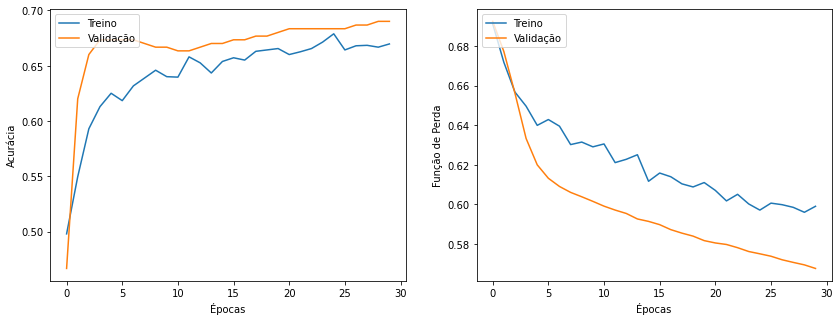

<Figure size 432x288 with 0 Axes>

In [18]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.legend(['Treino', 'Validação'], loc='upper left')

plt.subplot(122)
plt.ylabel('Função de Perda')
plt.xlabel('Épocas')
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['Treino', 'Validação'], loc='upper left')

plt.show()
#plt.savefig('acc-loss_graphs.png')

In [14]:
# Avaliacoes sobre o modelo

# Prevendo a propabilidade da distribuicao do dataset
prediction=model.predict(X_test)#, verbose=1)

# Pegando a classe com maior probabilidade para cada exemplo
#y_pred=np.argmax(prediction, axis=1)
y_pred=np.round(prediction)

# Gerando o relatorio de classificacao
print(classification_report(y_test, y_pred, target_names=['yes', 'no']))

              precision    recall  f1-score   support

         yes       0.84      0.42      0.56       147
          no       0.62      0.92      0.74       153

    accuracy                           0.68       300
   macro avg       0.73      0.67      0.65       300
weighted avg       0.73      0.68      0.65       300



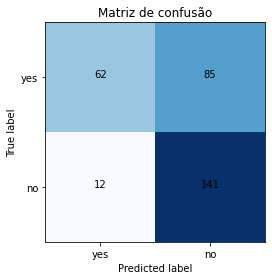

In [26]:
# Elaborando plot para matriz de confusão
class_names=['yes', 'no']
cm=confusion_matrix(y_test, y_pred)
title="Matriz de confusão"
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks=np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
thresh=cm.max()/2

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="black")
             #color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [27]:
#Gerando métricas de análise mais precisas
tp = cm[0][0]
fn = cm[0][1]
fp = cm[1][0]
tn = cm[1][1]

acc = ((tp+tn)*100)/np.sum(cm)
preci = (tp*100)/(tp+fp)
sensi = (tp*100/(tp+fn))
speci = (tn*100)/(fp+tn)

print('Métrica de Análise\n')
print(f'Acurácia: {acc:.2f} %')
print(f'Precisão: {preci:.2f} %')

print(f'Sensibilidade: {sensi:.2f} %')
print(f'Especificidade: {speci:.2f} %')

Métrica de Análise

Acurácia: 67.67 %
Precisão: 83.78 %
Sensibilidade: 42.18 %
Especificidade: 92.16 %
